In [1]:
#Importing all the neccesary libraries
import numpy as np 
import pandas as pd 
import csv

import os
print(os.listdir("input"))

import regex as re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer


# viz
import matplotlib.pyplot as plt
%matplotlib inline
import sys

# for clustering
from scipy.cluster.hierarchy import ward, dendrogram, fcluster, single, complete, average, weighted
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score

['.ipynb_checkpoints', '951967.zip', 'Bug report 10.csv', 'Bug report 100.csv', 'Bug report.csv', 'JIRA-ALL.csv', 'JIRA-BUG.csv', 'JIRA.csv', 'preprocessed_data.csv']


In [2]:
data=pd.read_csv('Input/JIRA-BUG.csv')
data = data.reset_index()
data.head()

,index,Summary,Bug Location,Issue key,Issue id,Issue Type,Status,Project key,Project name,Project type,...,Comment.64,Comment.65,Comment.66,Comment.67,Comment.68,Comment.69,Comment.70,Parent,Parent summary,Status Category
0,0,[Dev][Demo][Admin Portal][Edit Bundle items]: ...,Admin Portal,CORE-4396,57063,Bug,To Do,CORE,Justice - Core Team,software,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,To Do
1,1,[Dev][Admin Portal][Create New][Create From ex...,Admin Portal,CORE-4385,57039,Bug,In Progress,CORE,Justice - Core Team,software,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,In Progress
2,2,Duplicate items while using Search items by ke...,Automation Test,CORE-4377,57007,Bug,To Do,CORE,Justice - Core Team,software,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,To Do
3,3,[AP] Default language and default region of st...,Admin Portal,CORE-4366,56971,Bug,QA,CORE,Justice - Core Team,software,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,In Progress
4,4,[Unity][SDK] Single draft store makes subscrip...,SDK,CORE-4365,56960,Bug,To Do,CORE,Justice - Core Team,software,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,To Do


In [3]:
cols_of_interest=["Summary", "Status","Description","Priority","Resolution", "Issue Type", "Bug Location"]
data=data[cols_of_interest]
print(data.shape)
data.head()

(651, 7)


,Summary,Status,Description,Priority,Resolution,Issue Type,Bug Location
0,[Dev][Demo][Admin Portal][Edit Bundle items]: ...,To Do,This issue occurs on *Add new bundle items.*\n...,P1,NaN,Bug,Admin Portal
1,[Dev][Admin Portal][Create New][Create From ex...,In Progress,This issue occurs on Create new Role and Creat...,P1,NaN,Bug,Admin Portal
2,Duplicate items while using Search items by ke...,To Do,"While making script for cleanup, we found that...",P2,NaN,Bug,Automation Test
3,[AP] Default language and default region of st...,QA,When we open Stores menu and look at the store...,P1,NaN,Bug,Admin Portal
4,[Unity][SDK] Single draft store makes subscrip...,To Do,The restriction of single draft store makes su...,P1,NaN,Bug,SDK


In [4]:
data.isnull().sum()

Summary          0
Status           0
Description     59
Priority         0
Resolution      97
Issue Type       0
Bug Location     0
dtype: int64

In [5]:
data.Description = data.Description.fillna("0")
data.isnull().sum()

Summary          0
Status           0
Description      0
Priority         0
Resolution      97
Issue Type       0
Bug Location     0
dtype: int64

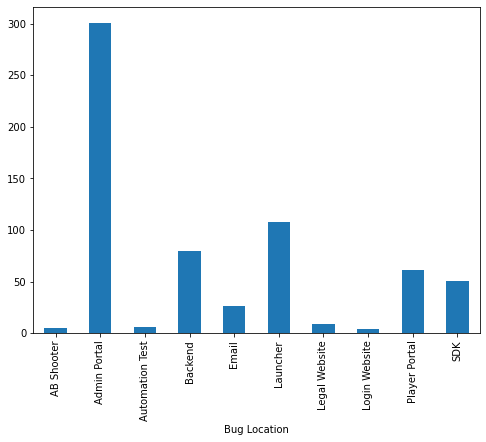

In [6]:
fig = plt.figure(figsize=(8,6))
data.groupby('Bug Location').Summary.count().plot.bar(ylim=0)
plt.show()

**Text data preprocessing steps**

1- Data Cleaning(either using regex or BeautifulSoup): 
a) Removing HTML characters. 
b) Removing punctuation. 
c) Decoding encoded data.
d) Split attached words.
e) Removing URLs. 
f) Apostrophe removal.
g) Removing Expressions. 
h) Uppercase & Lowercase letters 
i) Numbers such as amounts and data.

2- Data Tokenization(using word_tokenize in nltk.tokenize) 
Segregation of text into individual words i.e tokens.

3- Stopword Removal(using stopwords in nltk.corpus)
Discarding too common words or words which are not going to be helpful in our analysis.

4- Stemming(using WordNetLemmatizer in nltk.stem) 
Combining different variants of words into a single parent word that conveys same meaning.

In [7]:
stops = set(stopwords.words("english"))

In [8]:
dataConcat = pd.DataFrame()
dataConcat = data.Summary +" "+data.Status +" "+ data.Description+" "+data["Bug Location"]
dataConcat.to_csv("./Output/data_concat.csv")

In [9]:
dataConcat

0      [Dev][Demo][Admin Portal][Edit Bundle items]: ...
1      [Dev][Admin Portal][Create New][Create From ex...
2      Duplicate items while using Search items by ke...
3      [AP] Default language and default region of st...
4      [Unity][SDK] Single draft store makes subscrip...
                             ...                        
646    [STG][Launcher]Launcher didn't start automatic...
647    [STG][Launcher]Setting didn't revert to last s...
648    [STG][AP] Most of admin Portal features and co...
649    [STG][AP] There is no option to update client ...
650    [Backend]Can get the same user using different...
Length: 651, dtype: object

In [10]:
def clean_Description(content):
#     content = table.Description
    #Converting text to lowercase characters
    content = content.apply(lambda x: x.lower())
    #Removing HTML tags
    content = content.apply(lambda x: re.sub(r'\<[^<>]*\>','',x))
    #Removing any character which does not match to letter,digit or underscore
    content = content.apply(lambda x: re.sub(r'^\W+|\W+$',' ',x))
    #Removing space,newline,tab
    content = content.apply(lambda x: re.sub(r'\s',' ',x))
    #Removing punctuation
    content = content.apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))
    #Removing numeric
    content = content.apply(lambda x: re.sub(r'[0-9]','',x))
    #Tokenizing data
    content = content.apply(lambda x: word_tokenize(x))
    #Removing stopwords
    content = content.apply(lambda x: [i for i in x if i not in stops])
    type(content)
    return(content)

In [11]:
dataClean = clean_Description(dataConcat)

In [12]:
dataClean.head()

0    [dev, demo, portal, edit, bundle, items, add, ...
1    [dev, portal, create, new, create, existing, a...
2    [duplicate, items, using, search, items, keywo...
3    [ap, default, language, default, region, store...
4    [unity, sdk, single, draft, store, makes, subs...
dtype: object

## Stemming

In [13]:
data.dtypes

Summary         object
Status          object
Description     object
Priority        object
Resolution      object
Issue Type      object
Bug Location    object
dtype: object

In [14]:
wordnet = WordNetLemmatizer()
dataClean = dataClean.apply(lambda x:[wordnet.lemmatize(i,pos='v') for i in x])

# snowball = SnowballStemmer("porter")
# data.Concat = data.Concat.apply(lambda x:[snowball.stem(i) for i in x])

In [15]:
dataClean.head()

0    [dev, demo, portal, edit, bundle, items, add, ...
1    [dev, portal, create, new, create, exist, able...
2    [duplicate, items, use, search, items, keyword...
3    [ap, default, language, default, region, store...
4    [unity, sdk, single, draft, store, make, subsc...
dtype: object

In [31]:
dataClean

0      [dev, demo, portal, edit, bundle, items, add, ...
1      [dev, portal, create, new, create, exist, able...
2      [duplicate, items, use, search, items, keyword...
3      [ap, default, language, default, region, store...
4      [unity, sdk, single, draft, store, make, subsc...
                             ...                        
646    [stg, launcher, launcher, start, automaticaly,...
647    [stg, launcher, set, revert, last, save, setti...
648    [stg, ap, portal, feature, content, translate,...
649    [stg, ap, option, update, client, secret, clie...
650    [backend, get, use, different, namespace, summ...
Length: 651, dtype: object

In [16]:
Summary = dataClean.astype(str)
listOfSummary = list(dataClean)

# Hiearchical Clustering

 # Hierarchical Clustering Using Jaccard Coefficient and IDF

In [17]:
def calc_DF(tfDict):
    count_DF = {}
    # Run through each document's tf dictionary and increment countDict's (term, doc) pair
    for document in tfDict:
        for term in document:
            if term in count_DF:
                count_DF[term] += 1
            else:
                count_DF[term] = 1
    return count_DF

DF = calc_DF(listOfSummary)

In [18]:
with open('./Output/MyDFDict.csv', 'w') as f:
    for key in DF.keys():
        f.write("%s,%s\n"%(key,DF[key]))

In [19]:
n_document = len(listOfSummary)

def calc_IDF(__n_document, __DF):
    IDF_Dict = {}
    for term in __DF:
        IDF_Dict[term] = np.log(__n_document / (__DF[term] + 1))
    return IDF_Dict
  
#Stores the idf dictionary
IDF = calc_IDF(n_document, DF)

In [20]:
with open('./Output/MyIDFDict.csv', 'w') as f:
    for key in IDF.keys():
        f.write("%s,%s\n"%(key,IDF[key]))

In [21]:
def compute_jaccard(str1, str2):
    himpunan1 = set(str1)
    himpunan2 = set(str2)
    irisan = himpunan1.intersection(himpunan2)
    IDF_VAL = 0.0
    for key in irisan:
        IDF_VAL = IDF_VAL + IDF[key]
    IDF_VAL = IDF_VAL/(len(irisan)+1)
    gabungan = himpunan1.union(himpunan2)
#     jaccard = IDF_VAL
    jaccard = (len(irisan)/float(len(gabungan))) * IDF_VAL
    
    return jaccard

In [22]:
import itertools

sim_df = pd.DataFrame()

for col_pair in itertools.combinations_with_replacement(listOfSummary,2):
    strOfCol = str(col_pair)
    
    u0 = col_pair[0]
    u1 = col_pair[1]
    sim_df.loc[str(col_pair[0]), str(col_pair[1])] = compute_jaccard(u0, u1)

In [23]:
sim_df = sim_df.fillna(0)

In [24]:
dist = np.array(sim_df)

print(dist)

[[2.02804679 0.40845831 0.04811202 ... 0.06383067 0.11097362 0.07271771]
 [0.         1.80296947 0.09958111 ... 0.09139392 0.1200185  0.00971086]
 [0.         0.         3.04094274 ... 0.0286731  0.05651973 0.09445478]
 ...
 [0.         0.         0.         ... 2.3659199  0.67588811 0.29233256]
 [0.         0.         0.         ... 0.         2.32971873 0.25393221]
 [0.         0.         0.         ... 0.         0.         2.69650684]]


In [25]:
sim_df.to_csv("./Output/jcidf_matrix.csv")

## Agglomerative Hierarchical Clustering

In [26]:
linkage_matrix = weighted(dist) # replace with complete, single, or other scipy.cluster.hierarchical algorithms

In [32]:
linkage_matrix

array([[ 502.        ,  503.        ,    1.73577446,    2.        ],
       [ 325.        ,  548.        ,    1.80168608,    2.        ],
       [ 581.        ,  651.        ,    1.89496481,    3.        ],
       ...,
       [ 141.        , 1295.        ,    5.61748383,  643.        ],
       [ 333.        , 1296.        ,    5.71079607,  644.        ],
       [1291.        , 1297.        ,    6.08403461,  650.        ]])

In [27]:
np.savetxt("./Output/linkage_matrix_weighted.csv", linkage_matrix, delimiter=",")
dataCluster = pd.DataFrame()
dataCluster['token'] = dataClean
dataCluster['cluster'] = pd.Series(fcluster(Z=linkage_matrix, t=2, criterion='maxclust'))
dataCluster.to_csv("./Output/data_cluster_weighted.csv")

## Visualization

Dendrogram visualization. We visualize the titles of each paper next to the corresponding leaf to qualitatively evaluate the clustering.

Changing the `color_threshold` kwarg in the call to `dendrogram()` will affect how the clusters are displayed by increasing or decreasing the 
minimum distance necessary for `dendrogram()` to color a cluster differently.

In [28]:
# sys.setrecursionlimit(10000)
# MAX_COPHENETIC_DIST = max(linkage_matrix[:,2]) * 0.39 # max distance between points to be considered together. can be tuned.
# MAX_TITLE_LEN = 200

# fig, ax = plt.subplots(figsize=(15, 80)) # set size
# ax = dendrogram(linkage_matrix, orientation="right", color_threshold=MAX_COPHENETIC_DIST, leaf_font_size=4,
#                 labels=Summary.apply(lambda x: x if len(x) < MAX_TITLE_LEN else x[:MAX_TITLE_LEN  - 3] + "...").tolist())

# plt.tick_params(axis= 'x', which='both',  bottom='off', top='off',labelbottom='off')

# plt.tight_layout() #show plot with tight layout
# plt.savefig('./Output/jaccard-idf-coeff-ward.png', dpi=300)

# Analysis

We now take the raw clusters achieved and use the silhouette score and elbow method to evaluate.

In [29]:
def silhouette_k(distance_matrix, linkage_matrix, max_k=20):
    scores = []
    for i in range(2, max_k+1):
        clusters = fcluster(linkage_matrix, i, criterion='maxclust')
        score = silhouette_score(distance_matrix, clusters, metric='precomputed')
        print("Silhouette score with {} clusters:".format(i), score)
        scores.append(score)
    plt.title("Silhouette score vs. number of clusters")
    plt.xlabel("# of clusters")
    plt.ylabel("Score (higher is better)")
    plt.plot(np.arange(2, max_k+1), scores)
    plt.show()
    return scores

Silhouette score with 2 clusters: -0.9507274389259912
Silhouette score with 3 clusters: -0.9712367260017856
Silhouette score with 4 clusters: -0.9761289302425408
Silhouette score with 5 clusters: -0.975618666669585
Silhouette score with 6 clusters: -0.9817209679354222
Silhouette score with 7 clusters: -0.9805644098589568
Silhouette score with 8 clusters: -0.9810652457805618
Silhouette score with 9 clusters: -0.9795267842421002
Silhouette score with 10 clusters: -0.9802900655133668
Silhouette score with 11 clusters: -0.9787321661634024
Silhouette score with 12 clusters: -0.9771937046249408
Silhouette score with 13 clusters: -0.9761438481169612
Silhouette score with 14 clusters: -0.9755216823570142
Silhouette score with 15 clusters: -0.975413464206502
Silhouette score with 16 clusters: -0.9738728251246278
Silhouette score with 17 clusters: -0.9723225328396494
Silhouette score with 18 clusters: -0.9707802924658636
Silhouette score with 19 clusters: -0.9692289662182332
Silhouette score wit

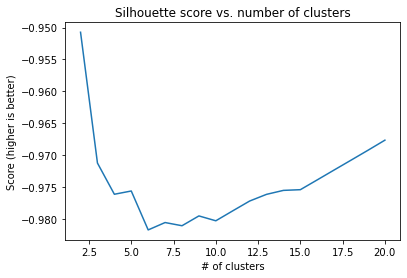

In [30]:
np.fill_diagonal(dist, 0)
_ = silhouette_k(dist, linkage_matrix)